In [3]:
import xarray as xr

# Open the NetCDF file
ds = xr.open_dataset("merged_ebd.nc")

# Check the contents
ds

<xarray.Dataset>
Dimensions:                       (_ind: 543087)
Coordinates:
  * _ind                          (_ind) float64 9.5e+11 9.5e+11 ... 1.26e+12
Data variables: (12/29)
    time                          (_ind) float64 ...
    sci_dvl_wi_err_vel            (_ind) float64 ...
    sci_dvl_wi_vel_good           (_ind) float64 ...
    sci_dvl_wi_x_vel              (_ind) float64 ...
    sci_dvl_wi_y_vel              (_ind) float64 ...
    sci_dvl_wi_z_vel              (_ind) float64 ...
    ...                            ...
    sci_rbrctd_timestamp          (_ind) float64 ...
    sci_satpar_par                (_ind) float64 ...
    sci_satpar_timestamp          (_ind) float64 ...
    sci_water_cond                (_ind) float64 ...
    sci_water_pressure            (_ind) float64 ...
    sci_water_temp                (_ind) float64 ...
Attributes: (12/18)
    num_ascii_tags:         14
    activeSensorList:       {'name': 'sci_ad2cp_file_state', 'unit': 'enum', ...
    dbd_label:              DBD(dinkum_binary_data)file
    encoding_ver:           5
    all_sensors:            T
    the8x3_filename:        00950000
    ...                     ...
    state_bytes_per_cycle:  41
    sensor_list_crc:        0fe22b9f
    sensor_list_factored:   1
    _dbdfiletimestamp:      1749125232.0
    _processing:            pyglider.slocum python library
    Conventions:            None

In [69]:
import numpy as np

# =========================
# QC Options per variable
# =========================
def getQCoptions(variableName):
    if variableName in ['sci_oxy4_oxygen', 'oxygen_concentration']:
        QCoptions = {
            'sensorMin': 0.1, 'sensorMax': 500,
            'sensor_userMin': 0.1, 'sensor_userMax': 450,
            'spike_thrshldLow': 5, 'spike_thrshldHigh': 10,
            'nDev': 5, 'time_dev': 600/3600,
            'min_wind_size': 5, 'eps': 1e-5,
            'repCntFail': 7, 'repCntSuspect': 5
        }
    elif variableName in ['sci_rbrctd_salinity_00', 'salinity']:
        QCoptions = {
            'sensorMin': 2, 'sensorMax': 40,
            'sensor_userMin': 10, 'sensor_userMax': 37,
            'spike_thrshldLow': 0.5, 'spike_thrshldHigh': 1.5,
            'nDev': 5, 'time_dev': 600/3600,
            'min_wind_size': 5, 'eps': 1e-5,
            'repCntFail': 7, 'repCntSuspect': 5
        }
    elif variableName in ['sci_rbrctd_conductivity_00', 'conductivity']:
        QCoptions = {
            'sensorMin': 0, 'sensorMax': 70, 
            'sensor_userMin': 1, 'sensor_userMax':60,
            'spike_thrshldLow': 5, 'spike_thrshldHigh': 6,
            'nDev': 5, 'time_dev': 600/3600,
            'min_wind_size': 5, 'eps': 1e-5,
            'repCntFail': 7, 'repCntSuspect': 5
        }
    elif variableName in ['sci_rbrctd_temperature_00', 'temperature']:
        QCoptions = {
            'sensorMin': -2, 'sensorMax': 40,
            'sensor_userMin': 2, 'sensor_userMax': 35,
            'spike_thrshldLow': 3.0, 'spike_thrshldHigh': 4.0,
            'nDev': 5, 'time_dev': 600/3600,
            'min_wind_size': 5, 'eps': 1e-5,
            'repCntFail': 7, 'repCntSuspect': 5
        }
    elif variableName in ['sci_rbrctd_seapressure_00', 'sci_rbrctd_pressure_00', 'pressure']:
        QCoptions = {
            'sensorMin': -2, 'sensorMax': 1200,
            'sensor_userMin': -2, 'sensor_userMax': 1200,
            'spike_thrshldLow': 5, 'spike_thrshldHigh': 10,
            'nDev': 5, 'time_dev': 600/3600,
            'min_wind_size': 5, 'eps': 1e-5,
            'repCntFail': 7, 'repCntSuspect': 5
        }
    else:
        raise ValueError(f"Unknown variableName '{variableName}'")
    return QCoptions


# =========================
# QC Test Functions
# =========================
def rangeCheckTest(var, QCflag, sensorMin, sensorMax, userMin, userMax):
    QCflag[(var < sensorMin) | (var > sensorMax)] = 4
    mask = ((var < userMin) | (var > userMax)) & (QCflag != 4)
    QCflag[mask] = 3
    return QCflag

def spikeTest(var, QCflag, thrshldLow, thrshldHigh):
    var = np.asarray(var)
    nonNANindices = np.where(~np.isnan(var))[0]
    for i in nonNANindices[1:-1]:
        spkRef = (var[i - 1] + var[i + 1]) / 2
        spike = np.abs(var[i] - spkRef)
        if thrshldLow < spike <= thrshldHigh:
            QCflag[i] = 3
        elif spike > thrshldHigh:
            QCflag[i] = 4
    return QCflag

def rateOfChangeTest(var, time, QCflag, nDev, timDev, minWindowSize):
    if not isinstance(time[0], np.datetime64):
        time = np.array(time, dtype='datetime64[ns]')
    recentData = []
    for i in range(1, len(var)):
        if np.isnan(var[i]) or np.isnan(var[i - 1]):
            continue
        timeDiff = (time[i] - time[i - 1]).astype('timedelta64[s]').astype(float) / 3600
        if timeDiff <= 0: continue
        rateOfChange = np.abs(var[i] - var[i - 1]) / (timeDiff + 1e-8)
        recentData = [(t, v) for t, v in recentData if (time[i] - t).astype('timedelta64[h]').astype(float) < timDev]
        recentData.append((time[i - 1], var[i - 1]))
        if len(recentData) < minWindowSize: continue
        values = [v for t, v in recentData]
        ratesOfChange = np.diff(values) / np.diff([t.astype(float) for t, _ in recentData])
        threshold = np.mean(ratesOfChange) + nDev * np.std(ratesOfChange, ddof=1)
        if rateOfChange > threshold: QCflag[i] = 3
    return QCflag

def flatLineTest(var, QCflag, eps, repCntFail, repCntSuspect):
    repeatCount = 0
    for i in range(1, len(var)):
        if np.isnan(var[i]) or np.isnan(var[i - 1]): repeatCount = 0; continue
        if abs(var[i] - var[i - 1]) < eps: repeatCount += 1
        else: repeatCount = 0
        if not np.isclose(var[i], 0, atol=1e-8):
            if repeatCount >= repCntFail - 1: QCflag[i] = 4
            elif repeatCount >= repCntSuspect - 1: QCflag[i] = 3
    return QCflag


# =========================
# Full QC Function on data
# =========================
def quartodQCchecks(var, time, variableName, QCoptions=None):
    var = np.asarray(var)
    QCflag = np.ones_like(var, dtype=int)
    QCflag[np.isnan(var) | np.isclose(var, 0, atol=1e-8)] = 9
    if QCoptions is None: QCoptions = getQCoptions(variableName)
    QCflag = rangeCheckTest(var, QCflag, QCoptions['sensorMin'], QCoptions['sensorMax'],
                            QCoptions['sensor_userMin'], QCoptions['sensor_userMax'])
    print(np.sum(QCflag==3), np.sum(QCflag==4)) 
    QCflag = spikeTest(var, QCflag, QCoptions['spike_thrshldLow'], QCoptions['spike_thrshldHigh'])
    print(np.sum(QCflag==3), np.sum(QCflag==4)) 
    QCflag = rateOfChangeTest(var, time, QCflag, QCoptions['nDev'], QCoptions['time_dev'], QCoptions['min_wind_size'])
    print(np.sum(QCflag==3), np.sum(QCflag==4)) 
    QCflag = flatLineTest(var, QCflag, QCoptions['eps'], QCoptions['repCntFail'], QCoptions['repCntSuspect'])
    print(np.sum(QCflag==3), np.sum(QCflag==4)) 
    var_clean = var.copy()
    var_clean[QCflag >= 3] = np.nan
    return QCflag, var_clean

# =========================
# Apply QC and add attributes
# =========================
variables_to_QC = ['sci_oxy4_oxygen', 'sci_rbrctd_salinity_00', 'sci_rbrctd_conductivity_00', 
                   'sci_rbrctd_temperature_00', 'sci_rbrctd_seapressure_00']

for varname in variables_to_QC:
    print(f"Applying QC to {varname}...")
    QCflag, var_QCclean = quartodQCchecks(ds[varname].values, ds['time'].values, varname)
    
    # Add to dataset
    ds[varname + '_QC'] = (('_ind'), QCflag)
    ds[varname + '_QCclean'] = (('_ind'), var_QCclean)

    # Auto-attributes for QC flags
    ds[varname + '_QC'].attrs.update({
        'long_name': f'QC flags for {varname}',
        'standard_name': f'{varname}_status_flag',
        'units': '1',
        'flag_meanings': "1=Pass 2=Not tested 3=Suspect 4=Fail 9=Missing or NaN",
        'tests_applied': "Gross range, Spike, Rate of change, Flat line"
    })

    # Auto-attributes for QC-cleaned variable
    ds[varname + '_QCclean'].attrs.update({
        'long_name': f'QC-cleaned {varname}',
        'comment': "Data points flagged as Suspect (3) or Fail (4) were set to NaN",
        'units': ds[varname].attrs.get('units', '')
    })

print("QC applied successfully. Flags stored in *_QC, cleaned variables in *_QCclean.")


Applying QC to sci_oxy4_oxygen...
0 246
0 246
0 246
0 246
Applying QC to sci_rbrctd_salinity_00...
0 246
0 246
0 246
0 246
Applying QC to sci_rbrctd_conductivity_00...
246 156
246 157
246 157
246 157
Applying QC to sci_rbrctd_temperature_00...
353 0
351 4
351 4
354 4
Applying QC to sci_rbrctd_seapressure_00...
0 0
0 0
0 0
0 0
QC applied successfully. Flags stored in *_QC, cleaned variables in *_QCclean.


In [66]:
ds

<xarray.Dataset>
Dimensions:                             (_ind: 543087)
Coordinates:
  * _ind                                (_ind) float64 9.5e+11 ... 1.26e+12
Data variables: (12/40)
    time                                (_ind) float64 1.749e+09 ... 1.75e+09
    sci_dvl_wi_err_vel                  (_ind) float64 ...
    sci_dvl_wi_vel_good                 (_ind) float64 ...
    sci_dvl_wi_x_vel                    (_ind) float64 ...
    sci_dvl_wi_y_vel                    (_ind) float64 ...
    sci_dvl_wi_z_vel                    (_ind) float64 ...
    ...                                  ...
    sci_oxy4_oxygen_QCclean             (_ind) float64 nan nan nan ... nan nan
    sci_rbrctd_salinity_00_QCclean      (_ind) float64 nan nan nan ... nan nan
    sci_rbrctd_conductivity_00_QCclean  (_ind) float64 nan nan nan ... nan nan
    sci_rbrctd_temperature_00_QCclean   (_ind) float64 nan nan nan ... nan nan
    sci_rbrctd_seapressure_00_QC        (_ind) int32 9 9 9 9 9 9 ... 9 9 9 9 9 9
    sci_rbrctd_seapressure_00_QCclean   (_ind) float64 nan nan nan ... nan nan
Attributes: (12/18)
    num_ascii_tags:         14
    activeSensorList:       {'name': 'sci_ad2cp_file_state', 'unit': 'enum', ...
    dbd_label:              DBD(dinkum_binary_data)file
    encoding_ver:           5
    all_sensors:            T
    the8x3_filename:        00950000
    ...                     ...
    state_bytes_per_cycle:  41
    sensor_list_crc:        0fe22b9f
    sensor_list_factored:   1
    _dbdfiletimestamp:      1749125232.0
    _processing:            pyglider.slocum python library
    Conventions:            None

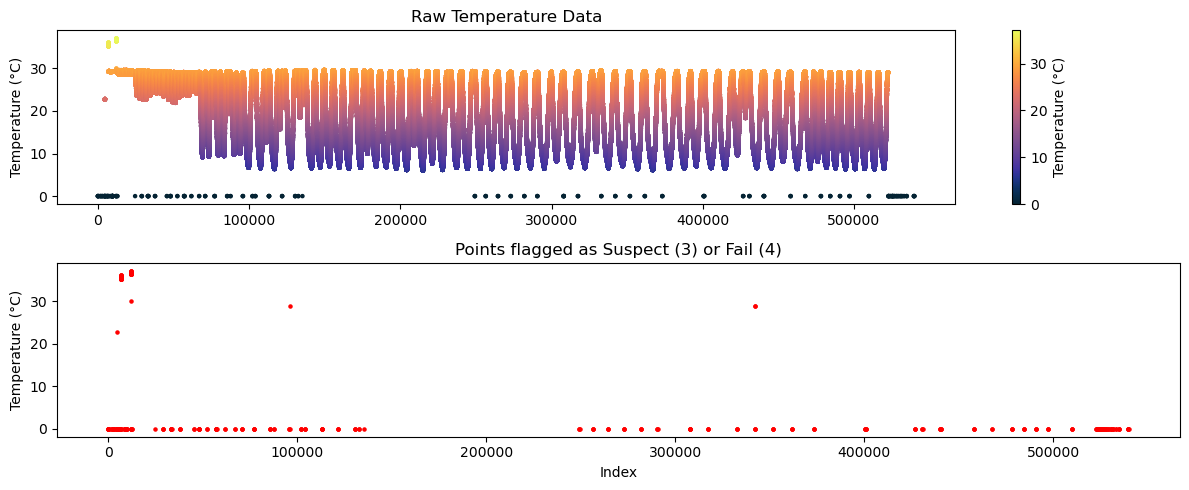

Total points: 543087
Suspect/Fail points: 358


In [68]:
import matplotlib.pyplot as plt
import cmocean

var_raw = ds['sci_rbrctd_temperature_00'].values
QCflag = ds['sci_rbrctd_temperature_00_QC'].values
x = np.arange(len(var_raw))

# Mask for suspect/fail points
flagged = (QCflag == 3) | (QCflag == 4)

plt.figure(figsize=(12,5))

# Panel 1: Raw data
plt.subplot(2,1,1)
sc = plt.scatter(x, var_raw, c=var_raw, cmap=cmocean.cm.thermal, s=5)
plt.colorbar(sc, label='Temperature (°C)')
plt.ylabel('Temperature (°C)')
plt.title('Raw Temperature Data')

# Panel 2: Flagged points only
plt.subplot(2,1,2)
plt.scatter(x[flagged], var_raw[flagged], color='red', s=5)
plt.ylabel('Temperature (°C)')
plt.xlabel('Index')
plt.title('Points flagged as Suspect (3) or Fail (4)')

plt.tight_layout()
plt.show()

print(f"Total points: {len(var_raw)}")
print(f"Suspect/Fail points: {np.sum(flagged)}")



